# Fake News & Marketing Detection

Initially, we planned to train the model on multiple datasets to detect both fake news and fake marketing. However, to align with the project requirements, we decided to use **ensemble learning**, and training on multiple datasets would have made the process longer and more complex. Instead, we chose to focus on a **single dataset**—the **Fake and Real News Dataset**—as it is large and sufficient for training and evaluation. This approach keeps things simple and allows us to compare model accuracy based on algorithms rather than dataset variations.


In [1]:
# STEP 1: Explanation of the Project & Dataset

"""
Fake News and Marketing Detection Project

Dataset:
- We have two CSV files: Fake.csv (23,502 articles) and True.csv (21,417 articles).
- Columns:
    1) title: title of the news article
    2) text: body text of the news article
    3) subject: subject/category of the article
    4) date: publish date of the news article

Goal:
- Detect whether a given news article is 'Fake' or 'Real' (binary classification).
- We'll explore the data, handle missing values, and compare multiple models:
    (a) BERTweet-based Transformer model
    (b) 4 classical ML models using TF-IDF features
    (c) An ensemble approach that combines model predictions via majority vote

We'll also show how each model predicts on sample texts, and finally how the ensemble decides.
"""
print("✓ Project & Dataset Explanation loaded. Proceed to next cell.")


✓ Project & Dataset Explanation loaded. Proceed to next cell.


In [2]:
# STEP 2: Install libraries (Kaggle/Colab). 

print("Installing required libraries...")
!pip install --quiet transformers datasets torch torchvision torchaudio sentencepiece
!pip install --quiet scikit-learn pandas tqdm matplotlib seaborn
print("✓ Libraries installed successfully")


Installing required libraries...
✓ Libraries installed successfully


In [3]:
# STEP 3: Import all necessary libraries

import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [4]:
# STEP 4: Environment setup (seed, device, constants)

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {device}")

# Constants for BERT training
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 2    # You can adjust to 3+ if you have enough time/GPU
MODEL_NAME = "vinai/bertweet-base"

print("✓ Constants defined:")
print(f"  - MAX_LENGTH={MAX_LENGTH}")
print(f"  - BATCH_SIZE={BATCH_SIZE}")
print(f"  - LEARNING_RATE={LEARNING_RATE}")
print(f"  - NUM_EPOCHS={NUM_EPOCHS}")
print(f"  - MODEL_NAME={MODEL_NAME}")


✓ Using device: cuda
✓ Constants defined:
  - MAX_LENGTH=128
  - BATCH_SIZE=16
  - LEARNING_RATE=2e-05
  - NUM_EPOCHS=2
  - MODEL_NAME=vinai/bertweet-base


In [5]:
# STEP 5: Load the Fake & Real News CSVs, basic EDA, handle missing data

print("Loading datasets...")
start_time = time.time()

# Adjust paths if needed:
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
true_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

print(f"✓ Datasets loaded in {time.time() - start_time:.2f} seconds\n")

# Label each dataframe
fake_df["label"] = 0  # Fake = 0
true_df["label"] = 1  # Real = 1

# Check for missing values quickly
print("Missing values in Fake.csv:")
print(fake_df.isnull().sum())
print("\nMissing values in True.csv:")
print(true_df.isnull().sum())

# For quick reference, let's see shapes
print(f"\nFake.csv shape: {fake_df.shape}")
print(f"True.csv shape: {true_df.shape}")

# Combine them
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"\nCombined dataset shape: {df.shape}")
print(df.head(3))

# Let's do some basic info
print("\nDataFrame info:")
df.info()

print("\nSummary of label distribution:")
print(df["label"].value_counts())


Loading datasets...
✓ Datasets loaded in 2.22 seconds

Missing values in Fake.csv:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Missing values in True.csv:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Fake.csv shape: (23481, 5)
True.csv shape: (21417, 5)

Combined dataset shape: (44898, 5)
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  

DataFr

Empty 'title' entries: 0
Empty 'text' entries: 631

After removing empty title/text, shape: (44267, 5)

Subject distribution:
subject
politicsNews       11271
worldnews          10145
News                9050
politics            6433
left-news           4309
Government News     1498
US_News              783
Middle-east          778
Name: count, dtype: int64


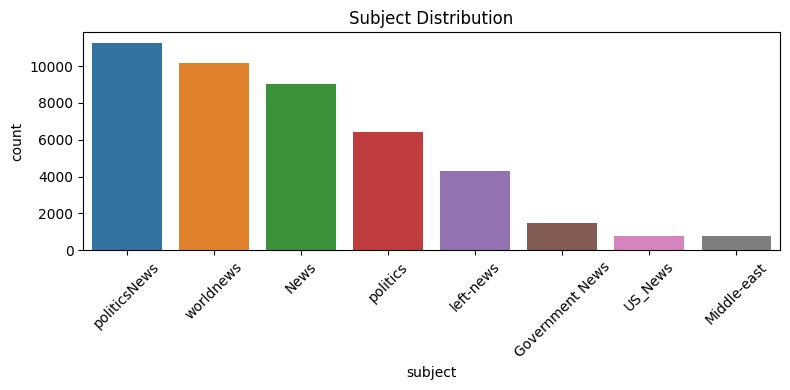

✓ Basic EDA & missing value handling done.


In [6]:
# STEP 6: More EDA, handling missing or empty text

# 1) Let's see if 'text' or 'title' are empty strings
missing_title = sum(df["title"].astype(str).apply(lambda x: x.strip()) == "")
missing_text = sum(df["text"].astype(str).apply(lambda x: x.strip()) == "")

print(f"Empty 'title' entries: {missing_title}")
print(f"Empty 'text' entries: {missing_text}")

# For demonstration, we might drop rows with empty text or title.
# This is optional depending on how you want to handle them.
df_cleaned = df[
    (df["title"].astype(str).apply(lambda x: x.strip()) != "") &
    (df["text"].astype(str).apply(lambda x: x.strip()) != "")
].copy()

print(f"\nAfter removing empty title/text, shape: {df_cleaned.shape}")

# Let's look at 'subject' distribution
print("\nSubject distribution:")
print(df_cleaned["subject"].value_counts())

# Quick plot of subject distribution
plt.figure(figsize=(8,4))
sns.countplot(data=df_cleaned, x="subject", order=df_cleaned["subject"].value_counts().index)
plt.title("Subject Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# We'll proceed with df_cleaned for modeling
df = df_cleaned.reset_index(drop=True)
print("✓ Basic EDA & missing value handling done.")


In [7]:
# STEP 7: Define a PyTorch Dataset for BERT training on news data

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        print(f"✓ Dataset initialized with {len(texts)} samples")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }

print("✓ NewsDataset class defined for BERT model.")


✓ NewsDataset class defined for BERT model.


In [8]:
# STEP 8: Split data for BERT, create DataLoader objects

# We'll use the 'title' for BERT, or we could combine 'title + text' if desired
# For demonstration, let's just use the title.
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

print("Train/Val/Test split completed.")
print(f"Train set: {len(train_df)}")
print(f"Val set:   {len(val_df)}")
print(f"Test set:  {len(test_df)}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("\nCreating BERT datasets...")
train_dataset_bert = NewsDataset(train_df["title"], train_df["label"], tokenizer, MAX_LENGTH)
val_dataset_bert   = NewsDataset(val_df["title"],   val_df["label"],   tokenizer, MAX_LENGTH)
test_dataset_bert  = NewsDataset(test_df["title"],  test_df["label"],  tokenizer, MAX_LENGTH)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE, shuffle=True)
val_loader_bert   = DataLoader(val_dataset_bert,   batch_size=BATCH_SIZE)
test_loader_bert  = DataLoader(test_dataset_bert,  batch_size=BATCH_SIZE)

print("✓ BERT DataLoaders created.")


Train/Val/Test split completed.
Train set: 30986
Val set:   6640
Test set:  6641


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]


Creating BERT datasets...
✓ Dataset initialized with 30986 samples
✓ Dataset initialized with 6640 samples
✓ Dataset initialized with 6641 samples
✓ BERT DataLoaders created.


In [9]:
# STEP 9: Define metrics, load BERTweet model for fine-tuning

def compute_metrics(pred):
    """Compute metrics for evaluation in HuggingFace Trainer."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True)
    
    return {
        "accuracy": accuracy,
        "f1": report["weighted avg"]["f1-score"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"]
    }

print("Loading BERTweet model...")
start_time = time.time()

model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model_bert.to(device)
print(f"✓ BERTweet loaded in {time.time() - start_time:.2f} seconds")


Loading BERTweet model...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ BERTweet loaded in 4.77 seconds


In [10]:
# STEP 10: Train the BERT model using HuggingFace Trainer

training_args = TrainingArguments(
    output_dir="./results_bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True if torch.cuda.is_available() else False,
    logging_dir="./logs_bert",
    logging_steps=10,
    report_to="none"
)

trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=compute_metrics
)

print("Starting BERT training...")
train_start = time.time()
trainer_bert.train()
train_end = time.time()
train_time = train_end - train_start
print(f"✓ BERT training completed in {train_time/60:.2f} minutes.")


Starting BERT training...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.036500,0.018451,0.998946,0.998946,0.998948,0.998946
2,0.000000,0.008292,0.999548,0.999548,0.999549,0.999548


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✓ BERT training completed in 17.44 minutes.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


BERT Test Accuracy: 0.9998
Classification Report (BERT):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3428
           1       1.00      1.00      1.00      3213

    accuracy                           1.00      6641
   macro avg       1.00      1.00      1.00      6641
weighted avg       1.00      1.00      1.00      6641



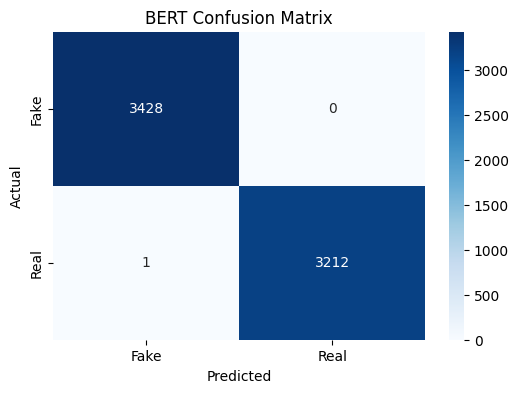

In [11]:
# STEP 11: Evaluate BERT on test set, show confusion matrix

test_results = trainer_bert.predict(test_dataset_bert)
y_preds_bert = test_results.predictions.argmax(-1)
y_true_bert = test_results.label_ids

acc_bert = accuracy_score(y_true_bert, y_preds_bert)
report_bert = classification_report(y_true_bert, y_preds_bert)
conf_mat_bert = confusion_matrix(y_true_bert, y_preds_bert)

print(f"BERT Test Accuracy: {acc_bert:.4f}")
print("Classification Report (BERT):")
print(report_bert)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake","Real"],
            yticklabels=["Fake","Real"])
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
# STEP 12: Prepare data for classical ML models using TF-IDF

# We'll combine title + text for classical models for richer features
df["combined_text"] = df["title"] + " " + df["text"]

# Split into train/test for classical
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(
    df["combined_text"], df["label"], 
    test_size=0.2, random_state=42, stratify=df["label"]
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_cl)
X_test_tfidf  = vectorizer.transform(X_test_cl)

print("✓ TF-IDF transformation complete.")
print(f"Train TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test TF-IDF shape:  {X_test_tfidf.shape}")


✓ TF-IDF transformation complete.
Train TF-IDF shape: (35413, 5000)
Test TF-IDF shape:  (8854, 5000)


In [13]:
# STEP 13: Train Logistic Regression, Naive Bayes, Random Forest, SVM

models = {}

# 1) Logistic Regression
lr = LogisticRegression(max_iter=300)
lr.fit(X_train_tfidf, y_train_cl)
models["LogisticRegression"] = lr

# 2) Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_cl)
models["NaiveBayes"] = nb

# 3) Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train_cl)
models["RandomForest"] = rf

# 4) SVM
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_tfidf, y_train_cl)
models["SVM"] = svm

print("✓ Classical models trained successfully.")


✓ Classical models trained successfully.


In [14]:
# STEP 14: Evaluate each classical model & print metrics

for name, model in models.items():
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test_cl, preds)
    report = classification_report(y_test_cl, preds)
    print("="*40)
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(report)

print("\n✓ Classical model evaluation complete.")


Model: LogisticRegression
Accuracy: 0.9876
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4571
           1       0.98      0.99      0.99      4283

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854

Model: NaiveBayes
Accuracy: 0.9322
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4571
           1       0.94      0.92      0.93      4283

    accuracy                           0.93      8854
   macro avg       0.93      0.93      0.93      8854
weighted avg       0.93      0.93      0.93      8854

Model: RandomForest
Accuracy: 0.9972
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4571
           1       1.00      1.00      1.00      4283

    accuracy                           1.00      8854
   macro avg 

In [15]:
# STEP 15: Create an ensemble using the classical models
# We decided not to include BERTweet in the ensemble as it would make things more complex,
# so we focused on combining the 4 classical models instead.
# We use a VotingClassifier to aggregate their predictions.

from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ("lr", models["LogisticRegression"]),
        ("nb", models["NaiveBayes"]),
        ("rf", models["RandomForest"]),
        ("svm", models["SVM"])
    ],
    voting='hard'  # or 'soft' if you prefer probability-based
)
ensemble_clf.fit(X_train_tfidf, y_train_cl)

# Evaluate ensemble
ensemble_preds = ensemble_clf.predict(X_test_tfidf)
ensemble_acc = accuracy_score(y_test_cl, ensemble_preds)
ensemble_report = classification_report(y_test_cl, ensemble_preds)

print("=== Ensemble (4 classical models) ===")
print(f"Accuracy: {ensemble_acc:.4f}")
print(ensemble_report)


=== Ensemble (4 classical models) ===
Accuracy: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4571
           1       0.99      0.99      0.99      4283

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [17]:
# STEP 16: Show how each model (including BERT) predicts new text

sample_texts = [
    "Breaking: Government announces new policies to combat misinformation",
    "Celebrity claims aliens built the pyramids in shocking interview",
    "Economy grows at fastest rate in a decade, experts confirm",
    "The White House announced a new healthcare initiative aimed at reducing prescription drug costs."
]

def predict_classical(text, model, vectorizer):
    """Predict class (Fake=0, Real=1) for classical model."""
    tfidf = vectorizer.transform([text])
    return model.predict(tfidf)[0]

def predict_bert(text, tokenizer, bert_model):
    """Predict class using BERT (Fake=0, Real=1)."""
    encoding = tokenizer(
        text,
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = bert_model(**encoding)
        probs = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    return predicted_class

print("=== Sample Text Predictions ===")
for i, txt in enumerate(sample_texts, 1):
    print(f"\nSample {i}: {txt[:60]}...")
    
    # 1) BERT
    bert_label = predict_bert(txt, tokenizer, model_bert)
    bert_str = "Real" if bert_label == 1 else "Fake"
    print(f"BERT: {bert_str}")
    
    # 2) Classical Models
    classical_predictions = {}
    for name, model in models.items():
        label = predict_classical(txt, model, vectorizer)
        label_str = "Real" if label == 1 else "Fake"
        classical_predictions[name] = label_str
    
    for name, label_str in classical_predictions.items():
        print(f"{name}: {label_str}")
    
    # 3) Ensemble
    ensemble_label = predict_classical(txt, ensemble_clf, vectorizer)
    ensemble_str = "Real" if ensemble_label == 1 else "Fake"
    print(f"Ensemble (Classical Voting): {ensemble_str}")


=== Sample Text Predictions ===

Sample 1: Breaking: Government announces new policies to combat misinf...
BERT: Real
LogisticRegression: Fake
NaiveBayes: Fake
RandomForest: Fake
SVM: Fake
Ensemble (Classical Voting): Fake

Sample 2: Celebrity claims aliens built the pyramids in shocking inter...
BERT: Real
LogisticRegression: Fake
NaiveBayes: Fake
RandomForest: Fake
SVM: Fake
Ensemble (Classical Voting): Fake

Sample 3: Economy grows at fastest rate in a decade, experts confirm...
BERT: Real
LogisticRegression: Fake
NaiveBayes: Real
RandomForest: Fake
SVM: Fake
Ensemble (Classical Voting): Fake

Sample 4: The White House announced a new healthcare initiative aimed ...
BERT: Real
LogisticRegression: Real
NaiveBayes: Real
RandomForest: Fake
SVM: Fake
Ensemble (Classical Voting): Fake
